Fe4N2 - 3 - calculations on the H-series 
=====================================

This part marks the conclusion of the three-part series tutorial,  and the user will learn how to conduct both emulator and hardware calculations using Quantinuum H-Series hardware on a system more complex than [H2](InQ_htut_Hser_H2.ipynb). It is important to note that one should run the [first part](InQ_tut_fe4n2_1.ipynb) and [second part](InQ_tut_fe4n2_2.ipynb) before proceeding to this tutorial. Additional details regarding the chemical systems, methodologies, and outcomes presented in this tutorial series are available in the associated [research paper](https://doi.org/10.1039/D3CP05167F). 

Let us move beyond a simple single-point energy calculation that is neither optimized nor variationally solved. Instead, we build upon the results obtained in the second part of this tutorial series, where the Adaptive Variational Quantum Eigensolver (ADAPT-VQE) algorithm was used to compute the total energy of the Fe$_3$N$_2$ molecule. This tutorial is also an extension of the initial part of the series, which provides detailed insights into the classical workflow necessary for defining the system.

To carry out these calculations, access to the Quantinuum systems is essential, and this access must be granted by the respective InQuanto administrator. Additionally, the user will require the appropriate credentials to run computations on a 6-qubit machine. Instructions on how to obtain access and in general more information about Quantinuum H-Series can be found on the linked [page](https://docs.quantinuum.com/inquanto/introduction/quantinuum_hardware.html) (for administrators).


Here are the steps outlined:

* Import the parameters characterizing the ground-state wavefunction.

* Conduct calculations on the Quantinuum emulator utilizing the PMSV error mitigation method.

* Execute calculations on the Quantinuum hardware using the PMSV error mitigation method.

To begin with, let us start by importing the qubit Hamiltonian, the fermionic state and space from the first part, along with the ground state parameters and the list of fermionic pool operators from the [second part](InQ_tut_fe4n2_2.ipynb) of this tutorial.

In [ ]:
import pickle

with open('InQ_tut_fe4n2_qubit_hamiltonian.pickle', 'rb') as handle:
    qubit_hamiltonian = pickle.load(handle)

with open('InQ_tut_fe4n2_state.pickle', 'rb') as handle:
    state = pickle.load(handle) 

with open('InQ_tut_fe4n2_space.pickle', 'rb') as handle:
    space = pickle.load(handle) 

with open('InQ_tut_fe4n2_gs_parameters.pickle', 'rb') as handle:
    gs_parameters = pickle.load(handle) 
    
with open('InQ_tut_fe4n2_exponents_with_symbols.pickle', 'rb') as handle:
    exponents_with_symbols = pickle.load(handle)

import warnings
warnings.filterwarnings('ignore')

InQuanto employs an efficient ansatz circuit compilation approach, provided by the `FermionSpaceStateExpChemicallyAware` class. This method is designed to minimize the computational resources required.

Parameters used:

- `fermion_operator_exponents` – Contains exponents and symbols. Assuming input exponents are ordered as single exponents first, followed by double exponents.
- `fermion_state` – Initial fermionic reference state.

In [ ]:
from inquanto.ansatzes import FermionSpaceStateExpChemicallyAware

ansatz=FermionSpaceStateExpChemicallyAware(fermion_operator_exponents=exponents_with_symbols, fermion_state=state)

The `state_circuit` attribute within InQuanto represents the symbolic state circuit, complete with a default compilation. In a Jupyter environment, one can visualize this symbolic state circuit by making use of the `render_circuit_jupyter` function provided by the pytket library.

In [ ]:
from pytket.circuit.display import render_circuit_jupyter

render_circuit_jupyter(ansatz.state_circuit)

To obtain a concise overview of the quantum resource costs associated with creating the Ansatz, one can utilize the `generate_report` method of the Ansatz object. This report typically includes information such as the circuit depth, total gate count, the count of Ansatz parameters, and the number of required qubits. In this circuit, the circuit depth is 133 and there are a total of 311 gates, 7 parameters and 6 qubits. These metrics provide an overview of the complexity and requirements of the quantum circuit. 
The circuit depth is the length of the longest path from the input (or from a preparation) to the output (or a measurement gate), moving forward in time along qubit wires.

For more in-depth diagnostics and analysis of the circuit, the user can examine the tket circuit object directly, which is usually accessed through `ansatz.state_circuit`. As an example, one can count the number of CNOT gates in the circuit. For further details on how to analyze tket circuits, the interested reader can refer to the [tket documentation](https://docs.quantinuum.com/tket/user-guide/examples/circuit_construction/circuit_analysis_example.html), which provides comprehensive information and guidance on this topic.


In [ ]:
from pytket.circuit import OpType

print('ANSATZ REPORT:')
print(ansatz.generate_report())
print(ansatz.get_circuit())
print('\n2-qubit GATES:  {}'.format(ansatz.circuit_resources()['gates_2q']))

ANSATZ REPORT:
{'ansatz_circuit_depth': 133, 'ansatz_circuit_gates': 311, 'n_parameters': 7, 'n_qubits': 6}
<tket::Circuit, qubits=6, gates=311>

CNOT GATES:  59


Conducting emulator experiments prior to hardware experiments is a pivotal phase in the development and optimization of quantum algorithms and applications. Emulators offer a controlled setting with the possibility to refine algorithms, explore quantum error correction techniques, and gain valuable insights into the performance of quantum circuits, all without being restricted by the limitations of physical hardware.
 
To simulate the specific noise profiles of machines, one can load and apply them to the simulations using the `QuantinuumBackend`, which retrieves information from the user's Quantinuum account. The `QuantinuumBackend` offers a range of available emulators, such as H1-1E and H1-2E. These emulators are designed for specific devices and they run remotely on a server.

Parameters used:

- `device_name` – Name of device, e.g. “H1-1”
- `label` – Job labels used if Circuits have no name, defaults to “job”
- `group` – String identifier of a collection of jobs, can be used for usage tracking.

In [ ]:
from pytket.extensions.quantinuum import QuantinuumBackend

backend = QuantinuumBackend(device_name="", label = "", group ="")#, label=" "

To reduce errors and inaccuracies caused by quantum noise and imperfections in the Quantinuum device, one can employ noise mitigation techniques. In this case, let us define the Qubit Operator symmetries within the system, which enables to utilize [PMSV](https://doi.org/10.1103/PhysRevResearch.4.033110) (Partition Measurement Symmetry Verification). PMSV is an efficient technique for symmetry-verified quantum calculations. It represents molecular symmetries using Pauli strings, including mirror planes (Z2) and electron-number conservation (U1). For systems with Abelian point group symmetry, qubit tapering methods can be applied. PMSV uses commutation between Pauli symmetries and Hamiltonian terms for symmetry verification. It groups them into sets of commuting Pauli strings. If each string in a set commutes with the symmetry operator, measurement circuits for that set can be verified for symmetry without additional quantum resources, discarding measurements violating system point group symmetries.

Parameters used:

`stabilizers` – List of state stabilzers as QubitOperators with only a single pauli strings in them.

The InQuanto `symmetry_operators_z2_in_sector` function is employed to retrieve a list of symmetry operators applicable to the system under consideration. These symmetry operators are associated with the point group, spin parity, and particle number parity Z2 symmetries that uphold a specific symmetry sector. The users can find additional details in the linked [page](https://docs.quantinuum.com/inquanto/api/inquanto/spaces.html#inquanto.spaces.FermionSpace.symmetry_operators_z2_in_sector).

In [ ]:
from inquanto.protocols.averaging._mitigation import PMSV
from inquanto.mappings import QubitMappingJordanWigner

stabilizers = QubitMappingJordanWigner().operator_map(
    space.symmetry_operators_z2_in_sector(
        state
    )
)

mitms_pmsv = PMSV(stabilizers)

Here, a technique known as "batching" is employed, wherein each experiment is iterated a certain number of times with a specific shot count as the target. For instance, if one aims for 10,000 shots, one conducts the experiment ten times, resulting in a total of 100,000 shots for that experiment. This limitation exists because each experiment can only accommodate a maximum of 10,000 shots and this implementation helps to avoid a single task from monopolizing the system's resources or a user accidentally using all their credits in a single instance.

To compute the expectation value of a Hermitian operator through operator averaging on the system register, the `PauliAveraging` protocol is employed. This protocol effectively implements the procedure outlined in ['Hamiltonian Averaging'](https://arxiv.org/abs/1407.7863). To launch the circuits to the backend the `launch` function is used. This method processes all the circuits associated with the expectation value calculations and returns a list of `ResultHandle` objects representing the handles for the results. One can pickle these `ResultHandle` objects so that the results can be easily retrieved. The user can monitor the progress of the experiments on the [Quantinuum page](https://um.qapi.quantinuum.com/user) by using the same credentials used to execute the experiments.

In [ ]:
from inquanto.protocols import PauliAveraging
from pytket.partition import PauliPartitionStrat


set_shots_10k = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
repeats = 10

#build and compile the circuits once
protocol_template = PauliAveraging(
    backend,
    shots_per_circuit=10000,
    pauli_partition_strategy=PauliPartitionStrat.CommutingSets
) 
protocol_template.build(gs_parameters, ansatz, qubit_hamiltonian, noise_mitigation=mitms_pmsv).compile_circuits()
protocol_pickle=protocol_template.dumps()
protocol_template.n_circuit

# launch 10 repeats of these circuits 
for i in range(repeats):
    protocol= PauliAveraging.loads(protocol_pickle, backend)
    handles = protocol.launch()
    with open( "handles_" + str(i) + ".pickle", 'wb') as handle:
        pickle.dump(handles, handle, protocol=pickle.HIGHEST_PROTOCOL)

After the experiments have finished, one can obtain the results by utilizing the `retrieve` function, which retrieves distributions from the backend for the specified source. The expectation value of a kernel for a specified quantum state is calculated by using the `evaluate_expectation_value` function. In addition, the `evaluate_expectation_uvalue` function can be used to calculate the expectation value of the Hermitian kernel while considering linear error propagation theory. The `std_dev` property returns the standard deviation which is used as the error associated with the calculation.

In [ ]:
repeats = 10
emulator_energies_10k =[]
emulator_10k = []

for i in range(repeats):
    with open("handles_" + str(i) + ".pickle", 'rb') as handle:
        handles = pickle.load(handle)
    #only need 1 copy of protocol to eval sets of results
    protocol.retrieve(handles)   
    energy_value = protocol.evaluate_expectation_value(ansatz, qubit_hamiltonian)
    emulator_energies_10k.append(energy_value)
    error= protocol.evaluate_expectation_uvalue(state, qubit_hamiltonian)
    emulator_10k.append(error)
    

Additionally, one can showcase circuit statistics after employing the `get_compiled_circuit` function to compile the sequence of circuits. In this case, both the circuit depth for each circuit measurement and the circuit depth associated with 2-qubit gates are visualized.

In [ ]:
for meas_circ in protocol.get_circuits():
     print("Circuit depth =", backend.get_compiled_circuit(meas_circ).depth())
     print("2qb gate depth =", backend.get_compiled_circuit(meas_circ).depth_by_type({OpType.CX, OpType.CZ}))

After completing the 10 repetitions, the mean value is computed. The mean value is used to determine the energy values for shot counts such as 20k, 30k, and so forth. Meanwhile, the standard deviation is used to calculate the error bars.

In [ ]:
import numpy as np

emulator_10k_mean = []  
for i in range (1,11):
    emulator_10k_mean.append(np.mean(emulator_energies_10k[:i]))

emulator_10k_std= [] 
for i in range (1,11):
    emulator_10k_std.append(numpy.std(emulator_10k[:i]))

This procedure can be reiterated for various sets of shots to analyze how the number of shots impacts the energy and error estimations.

In [ ]:
#target:5k
set_shots_5k = [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]

emulator_5k_mean = [-598.5233976942287, -598.528748007567, -598.5254365672856, -598.5266267836435,-598.5252272612659, 
                       -598.5241590945266, -598.5255975795899, -598.525113940237,-598.5249076903503, -598.5239581110884]

emulator_5k_std =[ 0,0.0016,0.0015,0.0014,0.0013,0.0012,0.0011, 0.0010,0.00095, 0.0009]



#target:4k
set_shots_4k = [4000, 8000, 12000, 16000, 20000, 24000, 28000, 32000, 36000, 40000]


emulator_4k_mean = [-598.5261956279538, -598.5239748592571, -598.5250271719032, -598.5236355685819, -598.5232948710519, 
                        -598.5243534836842, -598.5244650328887, -598.5251092284366, -598.524141170795, -598.5235882519817]

emulator_4k_std =[0,0.00163,0.00154,0.0015,0.0014,0.0013,0.0012,0.00115,0.0011, 0.0010]
                  


#target:2.5k
set_shots_2_5k = [2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000]

emulator_2_5k_mean = [-598.5386462829877, -598.528495041739, -598.5223780085176, -598.5221927569415, -598.5220793440851,
                    -598.522950988168, -598.5245581694165, -598.5236303692766, -598.5243398619134, -598.5237327682132]

emulator_2_5k_std =[0,0.0017,0.00165,0.0016,0.00155,0.0015,0.00145,0.0014,0.00135,0.0013]

Once collected all the results, one can proceed to visualize and analyze the data. By running the same set of instructions for different shot configurations, one can observe that the error bars notably decrease when a sufficiently large number of samples is used.

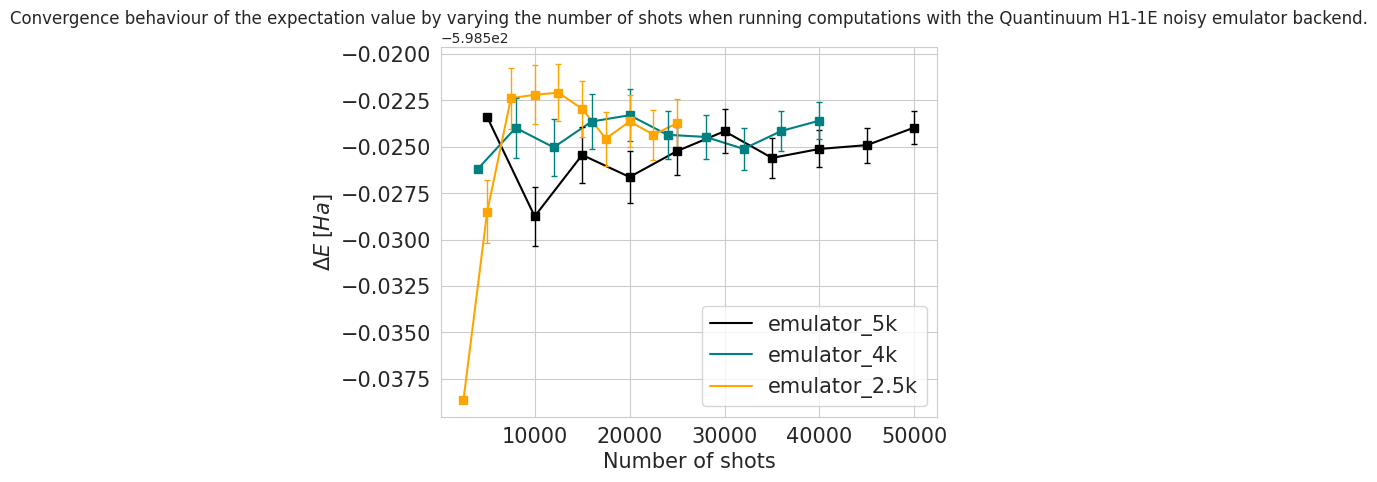

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

#plt.plot(set_shots_10k, emulator_10k_mean, label='emulator_10k',color='red')
plt.plot(set_shots_5k, emulator_5k_mean, label='emulator_5k',color='black')
plt.plot(set_shots_4k, emulator_4k_mean, label='emulator_4k',color='teal')
plt.plot(set_shots_2_5k, emulator_2_5k_mean, label='emulator_2.5k',color='orange')

plt.rcParams["figure.figsize"] = (10,6)
plt.xticks(fontsize=15 )
plt.yticks(fontsize=15 )

#y_error_10k = emulator_10k_std
y_error_5k = emulator_5k_std
y_error_4k = emulator_4k_std
y_error_2_5k = emulator_2_5k_std

#plt.errorbar(set_shots_10k,emulator_10k_mean,
#             yerr = y_error_10k, fmt ='s', color='red',
#             elinewidth=1,capsize=2)

plt.errorbar(set_shots_5k, emulator_5k_mean,
             yerr = y_error_5k, fmt ='s', color='black',
             elinewidth=1,capsize=2)

plt.errorbar(set_shots_4k, emulator_4k_mean,
             yerr = y_error_4k, fmt ='s', color='teal',
             elinewidth=1,capsize=2)

plt.errorbar(set_shots_2_5k, emulator_2_5k_mean,
             yerr = y_error_2_5k, fmt ='s', color='orange',
             elinewidth=1,capsize=2)

plt.xlabel('Number of shots',fontsize=15)
plt.ylabel('$\Delta E \; [Ha]$',fontsize=15)
plt.title("Convergence behavior of the expectation value by varying the number of shots when running computations with the Quantinuum H1-1E noisy emulator backend.")
plt.legend(fontsize=15)

With InQuanto, it is extremely easy to go from hardware emulation to hardware experiment. This is because `pytket.extensions.quantinuum` requires the same details for emulating the hardware as for sending the experiment to the physical quantum circuit, the only difference being the substitution of the name of the quantum device. For example, from 'H1-1E' to 'H1-1'. 

Here, only one series of experiments was performed on the hardware device. To limit the effects of noise in estimating expectation values, the PMSV method was used.

In this tutorial, three hardware experiments for three different structures of Fe$_4$N$_2$ cluster were performed in order to calculate the activation and dissociation energies of nitrogen on iron cluster.
More specifically, in this tutorial, the emulator calculations with 4000 shots were used. In addition, a hardware experiment was conducted simply by changing 'H1-1E' to 'H1-1', and these results served as the starting points in the figure below. 
Subsequently, one can re-run the calculations described in this tutorial, altering only the initial geometry in the first part. Namely, one can use the geometry where the N-N bond is stretched, representing the transition state and denoted as 'ts' in the figure. Finally, one can repeat the three tutorials once again, using a geometry where the N-N bond breaks, denoted as the 'end' in the figure. Notice that in these six experiments (two for each geometry), the single experiments with both the emulator and hardware were used instead of the batching method described above.
The primary goal of this tutorial is to offer a deeper understanding of how quantum computers can contribute to the comprehension of dissociation processes.

The electronic activation energy with respect to the kinetic constant of the process is calculated as $E_{Fe/N_2}^{tot}-E_{Fe/N_2^*}^{tot}$, while the activation energy is $E_{Fe/N_2}^{tot}-E_{Fe/2N}^{tot}$.
 
The data points computed on the hardware are in excellent agreement with the emulation results.

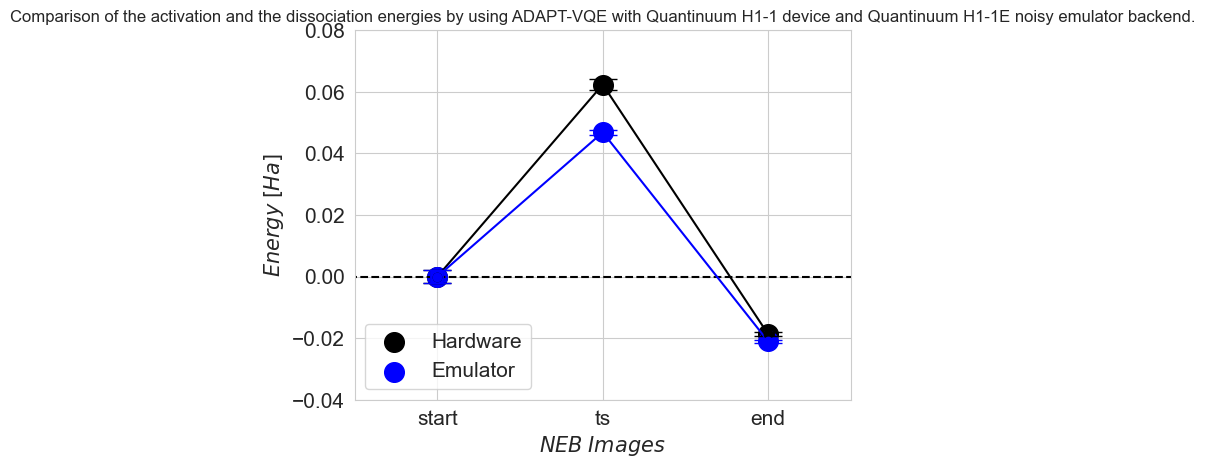

In [ ]:
# these are example solved energies from hardware and emulator

sns.set_style("whitegrid")

steps=[1,2,3]
emulator=[0,0.04681999999991149,-0.021029999999996107 ]
hardware=[0,0.06232999999997446,-0.018699999999967076]


plt.hlines(y=0, xmin=0, xmax=12, ls='--', colors='black')

plt.scatter(x=steps, y=hardware, s=200, c="black", label="Hardware") 
plt.plot(steps, hardware, c="black")

y_error_hard = [0.00196006200237305,0.00171393177265877,0.000768517902650537]
plt.errorbar(steps, hardware,
             yerr = y_error_hard, fmt ='o', color='black',
             elinewidth=10,capsize=10)


plt.scatter(x=steps, y=emulator, s=200, c="blue", label="Emulator") 
plt.plot(steps, emulator, c="blue")

y_error_em = [0.00222116960181585,0.000835916404261285,0.000489635318758811]

plt.errorbar(steps, emulator,
             yerr = y_error_em, fmt ='o', color='blue',
             elinewidth=10,capsize=10)


plt.ylabel('$Energy\; [Ha]$', fontsize=15)
plt.xlabel('$NEB \; Images\;$', fontsize=15)
plt.xticks(fontsize=15 )
plt.yticks(fontsize=15 )
plt.xlim([0.5, 3.5])
plt.ylim([-0.04, 0.08])
x=[1,2,3]
my_xticks = ['start','ts','end']
plt.xticks(x, my_xticks)
plt.legend(fontsize=15, loc='lower left')
plt.title("Comparison of the activation and the dissociation energies by using ADAPT-VQE with Quantinuum H1-1 device and Quantinuum H1-1E noisy emulator backend.")
plt.show()